<a href="https://colab.research.google.com/github/Qualot/deep-learning-from-scratch/blob/colab/ch07/im2col_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from keras.datasets import mnist
from keras.utils import to_categorical

In [27]:
np.set_printoptions(linewidth=10000)

In [28]:
x = np.random.rand(10, 3, 28, 28)
x.shape

(10, 3, 28, 28)

In [29]:
print(x[0].shape)
print(x[1].shape)

(3, 28, 28)
(3, 28, 28)


In [30]:
#Copied from the notebook/common.ipynb
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [31]:
#Copied from the notebook/common.ipynb
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

#im2col sample

In [32]:
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


#Common functions

In [33]:
def softmax(x):
  if x.ndim == 2:
      x = x.T
      x = x - np.max(x, axis=0)
      y = np.exp(x) / np.sum(np.exp(x), axis=0)
      return y.T

  x = x - np.max(x) # オーバーフロー対策
  return np.exp(x) / np.sum(np.exp(x))

In [34]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

#Common layers

In [35]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [36]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b
    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    return dx

In [37]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size
    return dx

#Convolution layer

In [38]:
class Convolution:
  def __init__(self, W, b, stride=1, pad=0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
    out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

    col = im2col(x, FH, FW, self.stride, self.pad)
    col_W = self.W.reshape(FN, -1).T
    out = np.dot(col, col_W) + self.b

    out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

    return out

#Pooling layer

In [39]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=2, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

  def forward(self, x):
    N, C, H, W = x.shape
    out_h = int(1 + (H - self.pool_h) / self.stride)
    out_w = int(1 + (W - self.pool_w) / self.stride)

    col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    out = np.max(col, axis=1)

    out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

    return out

#SimpleConvNet

In [40]:
class SimpleConvNet:
  def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num': 30, 'filter_size': 5, 'filter_num': 30, 'pad': 0, 'stride': 1}, hidden_size=100, output_size=10, weight_init_std=0.01):
    #hyperparameters
    filter_num = conv_param['filter_num']
    filter_size = conv_param['filter_size']
    filter_pad = conv_param['filter_pad']
    filter_stride = conv_param['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

    #weight parameters
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)

    #Layers
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

#Load MNIST and postprocessing (normalize, flatten, one-hot)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   

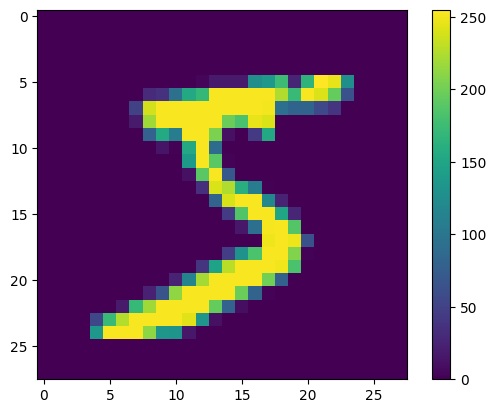

In [41]:
(x_train, t_train), (x_test, t_test) = mnist.load_data()
print(x_train[0])
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

#normalize
x_train, x_test = x_train / 255.0, x_test / 255.0

#flatten
x_train, t_train, x_test, t_test = [arr.reshape(arr.shape[0], -1) for arr in (x_train, t_train, x_test, t_test)]

#one-hot
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)

#Slicing sample

In [42]:
sample_x = np.arange(0,100,1).reshape(10, -1)
sample_y = np.zeros([10, 10])
print(sample_x)
for i in range(10):
  sample_y[:, -i-1] = sample_x[:, i]

print(sample_y)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[ 9.  8.  7.  6.  5.  4.  3.  2.  1.  0.]
 [19. 18. 17. 16. 15. 14. 13. 12. 11. 10.]
 [29. 28. 27. 26. 25. 24. 23. 22. 21. 20.]
 [39. 38. 37. 36. 35. 34. 33. 32. 31. 30.]
 [49. 48. 47. 46. 45. 44. 43. 42. 41. 40.]
 [59. 58. 57. 56. 55. 54. 53. 52. 51. 50.]
 [69. 68. 67. 66. 65. 64. 63. 62. 61. 60.]
 [79. 78. 77. 76. 75. 74. 73. 72. 71. 70.]
 [89. 88. 87. 86. 85. 84. 83. 82. 81. 80.]
 [99. 98. 97. 96. 95. 94. 93. 92. 91. 90.]]
